# Graph 2 Table Part 1 - Classify Plots

In [3]:
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil


## Preprocessing

### Cleaning

Convert all images to png; remove alpha chanels as needed

In [4]:
files = {
    'png': [],
    'png_alpha': [],
    'jpg': [],
    'other': [],
    'invalid': []
}

dataset_path = Path('./datasets/dataset_raw/')
for img_path in dataset_path.rglob('*'):

    if not img_path.is_file():
        continue # skip dirs    
    
    try:
        with Image.open(img_path) as img:

            img.verify() # check for corruption
            fmt = img.format.lower()
            mode = img.mode

            if fmt == 'png':
                if 'A' in mode or 'alpha' in mode.lower():
                    files['png_alpha'].append(img_path)
                else:
                    files['png'].append(img_path)

            elif fmt == 'jpeg':
                if 'A' in mode or 'alpha' in mode.lower():
                    files['other'].append(img_path) # jpegs shouldn't have an alpha chan.
                else:
                    files['jpg'].append(img_path)

            else:
                files['other'].append(img_path)
            
    except (UnidentifiedImageError, OSError):
        files['invalid'].append(img_path)
        
        

Display images of each category

In [5]:
for img_type, value in files.items():
    print(img_type, len(value))

png 0
png_alpha 3202
jpg 0
other 0
invalid 1


In [6]:
files['other']

[]

In [7]:
files['invalid']

[PosixPath('datasets/dataset_raw/.DS_Store')]

Remove alpha chanel from all the images and write to a new directory as PNG

In [8]:
dataset_clean_path = Path('./datasets/dataset_clean')
dataset_clean_path.mkdir(exist_ok=True)

In [ ]:
for img_path in dataset_path.rglob('*'):
    if not img_path.is_file():
        continue

    if img_path.suffix == '':
        continue

    class_dir = img_path.parts[1]
    filename = img_path.name
    output_path = dataset_clean_path / class_dir 
    output_path.mkdir(exist_ok=True)
    try:
        with Image.open(img_path) as img:
            if img.mode in ('RGBA', 'LA', 'P' ):
                rgb_img = img.convert('RGB')
                
                new_name = Path(output_path / filename).with_suffix('.png')
                rgb_img.save(new_name)
            else:
                img.save(output_path / filename)
    except Exception as e:
        print(f'Failed to process img_path: {e}')
            
            

Double check types again

In [123]:
files = {
    'png': [],
    'png_alpha': [],
    'jpg': [],
    'other': [],
    'invalid': []
}

dataset_path = Path('./datasets/dataset_clean/')
for img_path in dataset_path.rglob('*'):

    if not img_path.is_file():
        continue # skip dirs    
    
    try:
        with Image.open(img_path) as img:

            img.verify() # check for corruption
            fmt = img.format.lower()
            mode = img.mode

            if fmt == 'png':
                if 'A' in mode or 'alpha' in mode.lower():
                    files['png_alpha'].append(img_path)
                else:
                    files['png'].append(img_path)

            elif fmt == 'jpeg':
                if 'A' in mode or 'alpha' in mode.lower():
                    files['other'].append(img_path) # jpegs shouldn't have an alpha chan.
                else:
                    files['jpg'].append(img_path)

            else:
                files['other'].append(img_path)
            
    except (UnidentifiedImageError, OSError):
        files['invalid'].append(img_path)
        
        

In [124]:
for img_type, value in files.items():
    print(img_type, len(value))

png 2966
png_alpha 0
jpg 0
other 0
invalid 1


In [125]:
files['invalid']

[PosixPath('datasets/dataset_clean/.DS_Store')]

### Check Class Balance

In [126]:
dataset_path = Path('./datasets/dataset_clean/')

all_classes = {}
total = 0
for d in dataset_path.glob('*'):
    if d.is_dir():
        file_count = sum(1 for p in d.glob('*') if p.is_file())
        all_classes[d.name] = file_count
        total += file_count

for k, v in all_classes.items():
    print(f"{k:>12}: {v} - {v/total * 100:.2f}%")

   flowchart: 546 - 18.41%
    bargraph: 510 - 17.19%
    piechart: 711 - 23.97%
   linegraph: 497 - 16.76%
 scatterplot: 702 - 23.67%


### Split Data Set

Split into stratified 70/20/10 Train/Validate/Test

In [127]:
dataset_path = Path('./datasets/dataset_clean/')
all_images = []
all_labels = []

for class_dir in dataset_path.iterdir():
    if class_dir.is_dir():
        label = class_dir.name
        for img_path in class_dir.glob('*'):
            if img_path.suffix.lower() in {'.jpg', '.jpeg', '.png'}:
                all_images.append(img_path)
                all_labels.append(label)

X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3,
    stratify=all_labels, 
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size = 1/3, 
    stratify=y_temp,
    random_state=42
)

from collections import Counter
print('Train:', Counter(y_train))
print('Val:', Counter(y_val))
print('Test:', Counter(y_test))

Train: Counter({'piechart': 498, 'scatterplot': 491, 'flowchart': 382, 'bargraph': 357, 'linegraph': 348})
Val: Counter({'piechart': 142, 'scatterplot': 141, 'flowchart': 109, 'bargraph': 102, 'linegraph': 99})
Test: Counter({'piechart': 71, 'scatterplot': 70, 'flowchart': 55, 'bargraph': 51, 'linegraph': 50})


### Copy files for easy use later

In [128]:
def copy_files(dest_root, paths, labels):
    for path, label in zip(paths, labels):
        dest_dir = Path(dest_root) / label
        dest_dir.mkdir(parents=True, exist_ok=True)
        dest_path = dest_dir / path.name
        shutil.copy(path, dest_path)

copy_files('./datasets/dataset_train_validate_test/dataset_train', X_train, y_train)
copy_files('./datasets/dataset_train_validate_test/dataset_val',   X_val,   y_val)
copy_files('./datasets/dataset_train_validate_test/dataset_test',  X_test,  y_test)

### Make a sanity check set

As per Andrew Ng's ML Ops, we will make a small data set to test with a simple model to get started.

In [30]:
import random

dataset_path = Path('./datasets/dataset_clean/')
tiny_dataset_path = Path('./datasets/dataset_tiny')

num_samples = 10

for class_dir in dataset_path.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob('*'))
        sampled = random.sample(images, min(num_samples, len(images)))

        dest_class_dir = tiny_dataset_path / class_dir.name
        dest_class_dir.mkdir(parents=True, exist_ok=True)

        for img in sampled:
            shutil.copy(img, dest_class_dir / img.name)

## Build & Train Model V0

In [63]:
from tensorflow.keras import layers, models


def cnn_v0(input_shape=(128, 128, 3), num_classes=5):
    """sanity check model - simple"""
    model = models.Sequential([
        
        layers.Input(shape=input_shape),

        layers.Rescaling(1./255),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

### Load Tiny Dataset

In [36]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models

tiny_train_dataset = image_dataset_from_directory(
    './datasets/dataset_tiny/',
    image_size=(128, 128),
    batch_size=8,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

Found 97 files belonging to 5 classes.


### Compile and Train V0

In [66]:
# Define number of classes from the dataset
class_names = tiny_train_dataset.class_names
num_classes = len(class_names)
print(num_classes, class_names)

model_tiny = cnn_v0(num_classes=num_classes)

model_tiny.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', ]
)

history = model_tiny.fit(tiny_train_dataset, epochs=30)

5 ['bargraph', 'flowchart', 'linegraph', 'piechart', 'scatterplot']
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2094 - loss: 24.1940    
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0951 - loss: 8.4309     
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1821 - loss: 1.8162
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2601 - loss: 1.6522
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1888 - loss: 1.6315
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5653 - loss: 1.5099
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3914 - loss: 1.4728
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3255 - loss: 1.3961
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3864 - loss: 1.3400
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6296 - loss: 1.1640
Epoch 11/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5203 

### Visualize Training V0

Verify that the model can learn and there's nothing significantly wrong with the data. The model looks OK and the plot shows expected learning and decreasing loss.

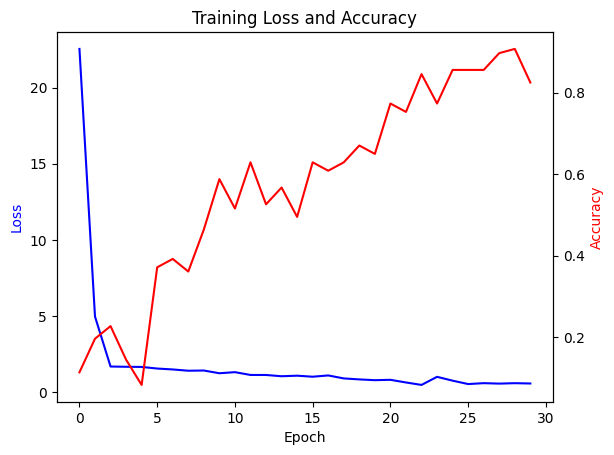

In [67]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(history.history['loss'], 'b-', label='Loss')
ax2.plot(history.history['accuracy'], 'r-', label='Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax2.set_ylabel('Accuracy', color='r')

plt.title('Training Loss and Accuracy')
plt.show()

In [68]:
history.history['accuracy']

[0.11340206116437912,
 0.19587628543376923,
 0.22680412232875824,
 0.14432989060878754,
 0.0824742242693901,
 0.3711340129375458,
 0.39175257086753845,
 0.36082473397254944,
 0.4639175236225128,
 0.5876288414001465,
 0.5154638886451721,
 0.6288659572601318,
 0.5257731676101685,
 0.5670102834701538,
 0.49484536051750183,
 0.6288659572601318,
 0.6082473993301392,
 0.6288659572601318,
 0.6701030731201172,
 0.6494845151901245,
 0.7731958627700806,
 0.7525773048400879,
 0.8453608155250549,
 0.7731958627700806,
 0.8556700944900513,
 0.8556700944900513,
 0.8556700944900513,
 0.8969072103500366,
 0.907216489315033,
 0.8247422575950623]

### Test With Full Dataset V0

Use larger batch sizes and a lower learning rate to smooth out some of the early over confidence.

In [129]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
train_dataset  = image_dataset_from_directory(
    './datasets/dataset_train_validate_test/dataset_train/',
    image_size=(128, 128),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=True
)

test_dataset  = image_dataset_from_directory(
    './datasets/dataset_train_validate_test/dataset_test/',
    image_size=(128, 128),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

val_dataset =  image_dataset_from_directory(
    './datasets/dataset_train_validate_test/dataset_val//',
    image_size=(128, 128),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

Found 2076 files belonging to 5 classes.
Found 297 files belonging to 5 classes.
Found 593 files belonging to 5 classes.


In [130]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define number of classes from the dataset
class_names = train_dataset.class_names
num_classes = len(class_names)
print(class_names)

model_full = cnn_v0(num_classes=num_classes)
checkpoint = ModelCheckpoint(
    'models/cnn_v0_best.keras',      # Save path
    monitor='val_accuracy',          # Metric to watch
    save_best_only=True,             # Only keep best
    save_weights_only=False,         # Save full model
    verbose=1
)

model_full.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', ]
)

history = model_full.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[checkpoint]
)

['bargraph', 'flowchart', 'linegraph', 'piechart', 'scatterplot']
Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2572 - loss: 1.6893
Epoch 1: val_accuracy improved from -inf to 0.45531, saving model to models/cnn_v0_best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2576 - loss: 1.6886 - val_accuracy: 0.4553 - val_loss: 1.3422
Epoch 2/30
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5108 - loss: 1.2594
Epoch 2: val_accuracy improved from 0.45531 to 0.59191, saving model to models/cnn_v0_best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5112 - loss: 1.2584 - val_accuracy: 0.5919 - val_loss: 1.0647
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6197 - loss: 1.0190
Epoch 3: val_accuracy improved from 0.59191 to 0.63912, saving model to models/cnn_v0_best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6197 - loss: 1.0189 - val_accuracy: 0.6391 - val_loss: 0.9730
Epoch 4/30
128/130 ━━━━━━━━━━━━

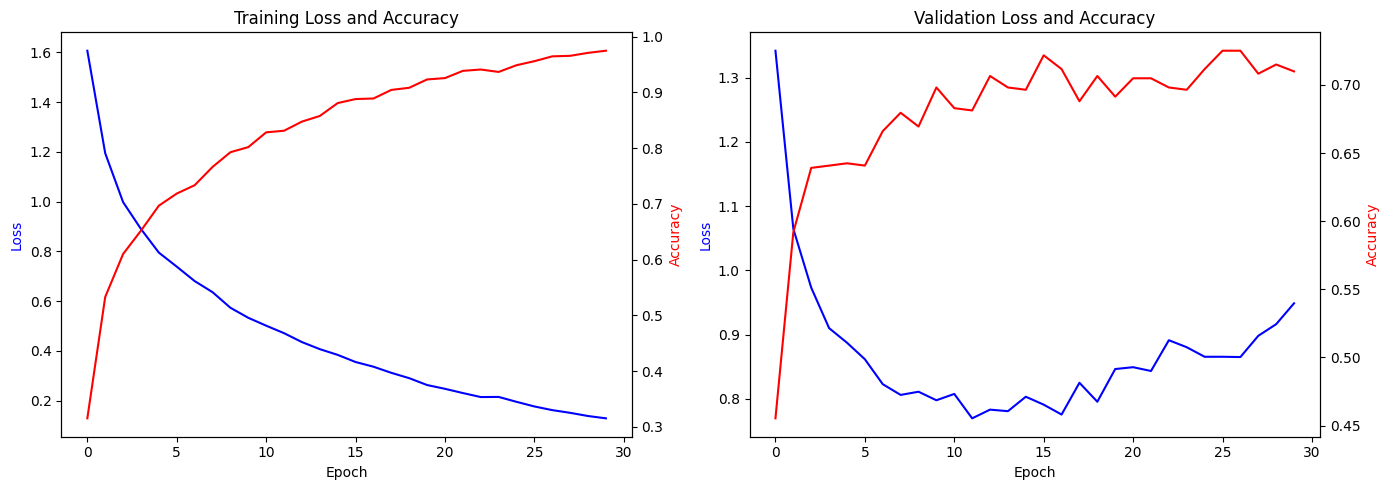

In [135]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss & Accuracy
ax1_twin = ax1.twinx()
ax1.plot(history.history['loss'], 'b-', label='Train Loss')
ax1_twin.plot(history.history['accuracy'], 'r-', label='Train Acc')

ax1.set_title('Training Loss and Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1_twin.set_ylabel('Accuracy', color='r')

# Plot 2: Validation Loss & Accuracy
ax2_twin = ax2.twinx()
ax2.plot(history.history.get('val_loss', []), 'b-', label='Val Loss')
ax2_twin.plot(history.history.get('val_accuracy', []), 'r-', label='Val Acc')

ax2.set_title('Validation Loss and Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss', color='b')
ax2_twin.set_ylabel('Accuracy', color='r')

plt.tight_layout()
plt.show()

### Check Labels

Labels look ok, but bargraph actually contains three sub-classes:

- stacked column
- bar graph

Many scatter and line plots share these qualities:

- dots
- lines / trend lines


Class: bargraph


2025-04-16 15:56:15.568946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


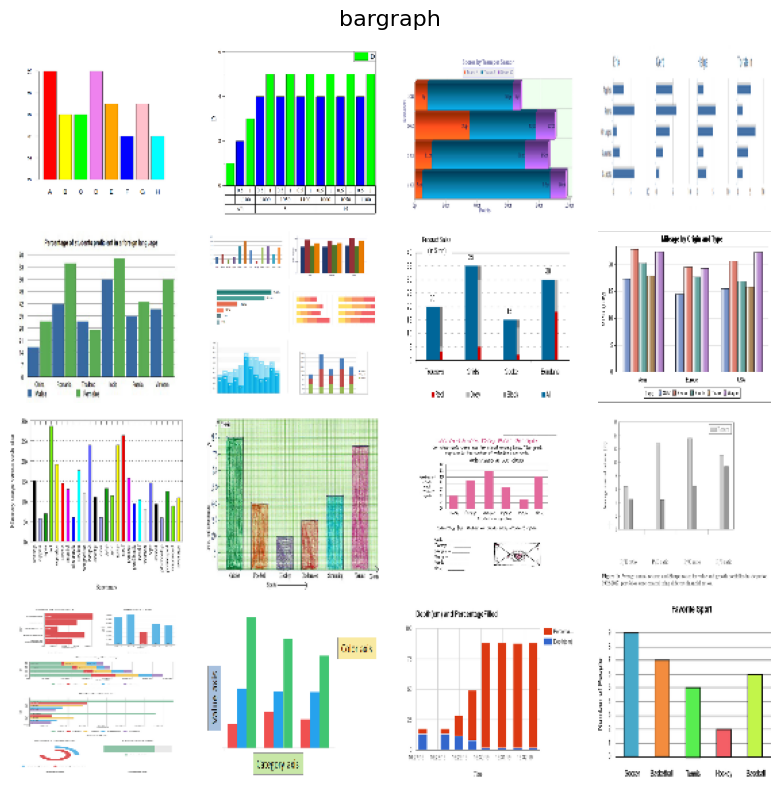


Class: flowchart


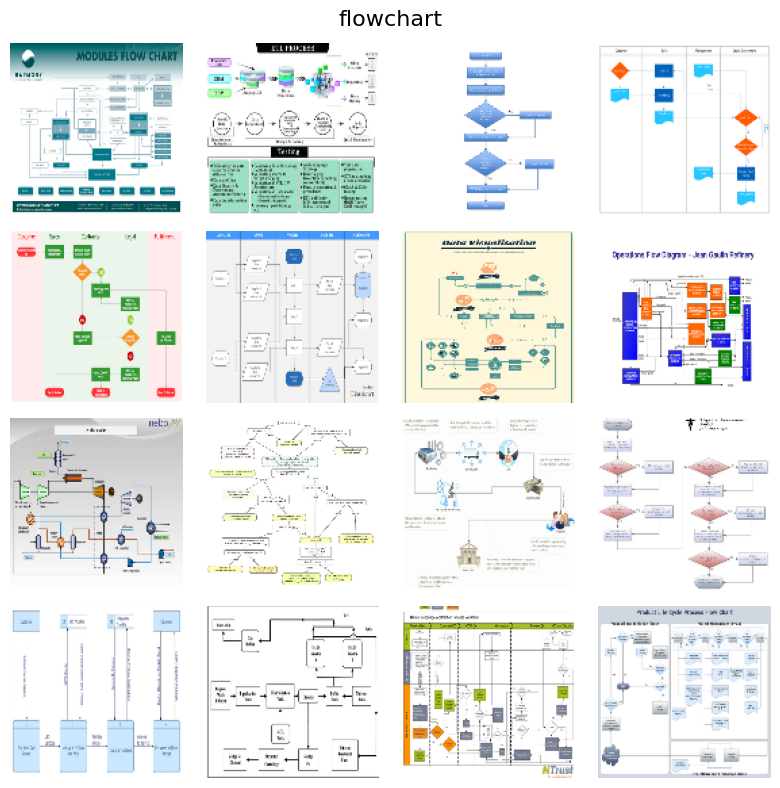


Class: linegraph


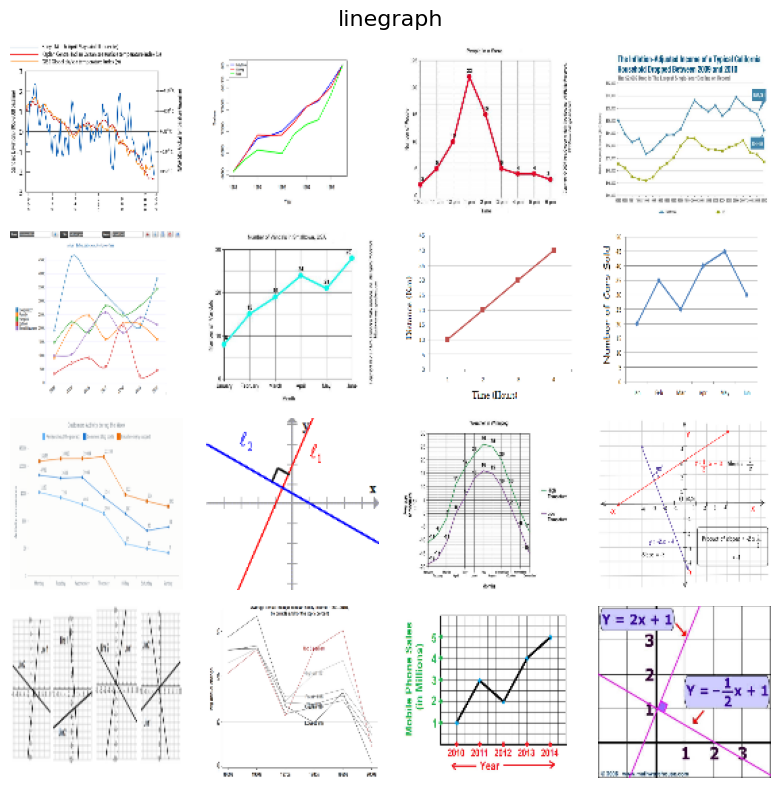


Class: piechart


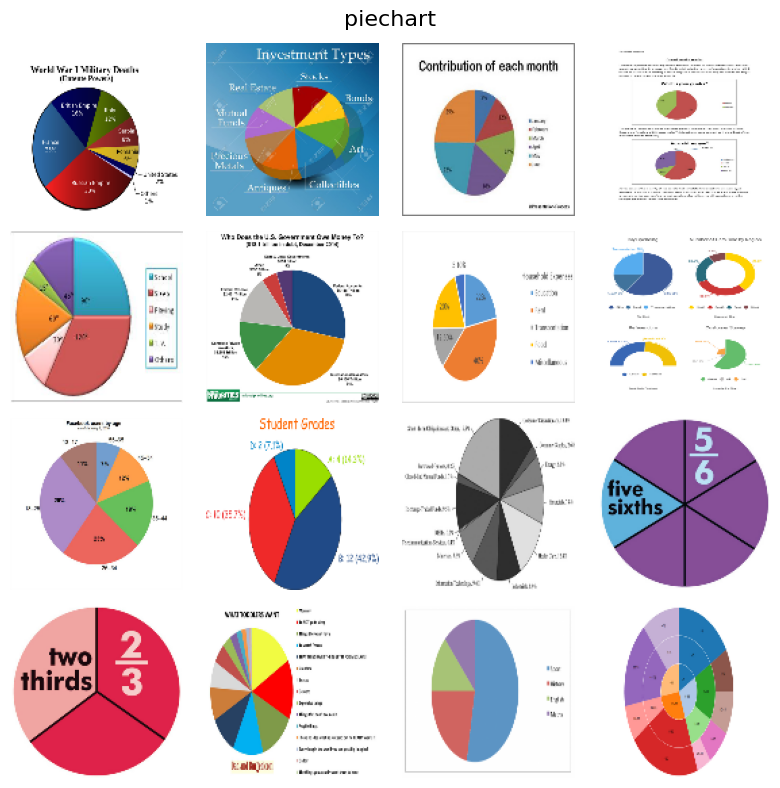


Class: scatterplot


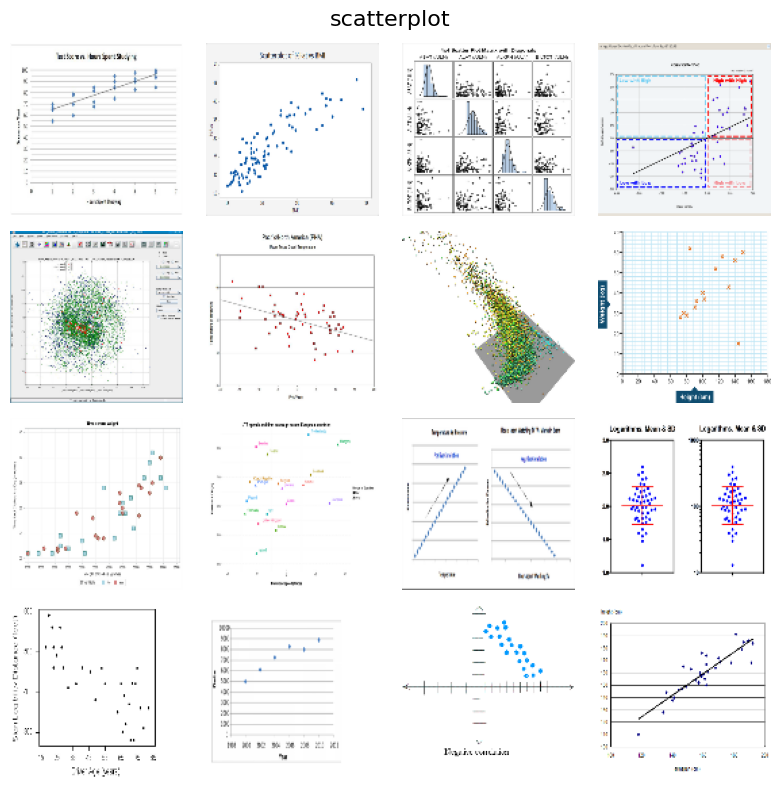

In [136]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Unbatch the dataset to get (image, label) pairs
all_images = list(train_dataset.unbatch())
class_names = train_dataset.class_names

for class_index, class_name in enumerate(class_names):
    print(f'\nClass: {class_name}')

    # Filter all images for the current class
    class_images = [img for img, label in all_images if label.numpy() == class_index]
    sample_images = random.sample(class_images, min(16, len(class_images)))

    # Create 4x4 subplot
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(f'{class_name}', fontsize=16)

    for ax, img in zip(axes.flatten(), sample_images):
        ax.imshow(img.numpy().astype("uint8"))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate 

# Step 1: Get predictions
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model_full.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

2025-04-16 16:26:54.090555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


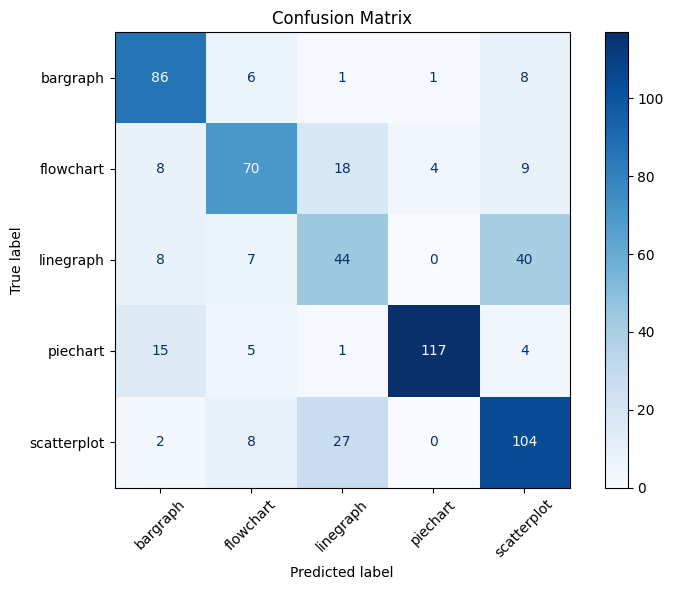


### Top Confusions
| True Class   | Predicted As   |   Count |
|--------------|----------------|---------|
| bargraph     | scatterplot    |       8 |
| flowchart    | linegraph      |      18 |
| linegraph    | scatterplot    |      40 |
| piechart     | bargraph       |      15 |
| scatterplot  | linegraph      |      27 |

### Model Performance (Weighted Averages)
| Metric    |   Value |
|-----------|---------|
| Accuracy  |  0.7099 |
| Precision |  0.7186 |
| Recall    |  0.7099 |
| F1 Score  |  0.7106 |

### Per-Class Metrics
| Class       |   Precision |   Recall |   F1 Score |   Support |
|-------------|-------------|----------|------------|-----------|
| bargraph    |      0.7227 |   0.8431 |     0.7783 |       102 |
| flowchart   |      0.7292 |   0.6422 |     0.6829 |       109 |
| linegraph   |      0.4835 |   0.4444 |     0.4632 |        99 |
| piechart    |      0.959  |   0.8239 |     0.8864 |       142 |
| scatterplot |      0.6303 |   0.7376 |     0.6797 |       141 |


In [156]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report
)
from tabulate import tabulate
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = val_dataset.class_names
num_classes = len(class_names)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Identify top confusion(s) per true class (with ties)
top_confusions = []
for i in range(num_classes):
    row = cm[i]
    off_diagonal = [(j, row[j]) for j in range(num_classes) if j != i and row[j] > 0]
    if off_diagonal:
        max_count = max(count for _, count in off_diagonal)
        tied = [(i, j, count) for j, count in off_diagonal if count == max_count]
        top_confusions.extend(tied)

# Print most common confusions
markdown_data = [(class_names[i], class_names[j], count) for i, j, count in top_confusions]
markdown_data.sort(key=lambda x: (x[0], -x[2]))
print('\n### Top Confusions')
print(tabulate(markdown_data, headers=['True Class', 'Predicted As', 'Count'], tablefmt='github'))

# Compute and print overall metrics
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print('\n### Model Performance (Weighted Averages)')
metric_table = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}'],
]
print(tabulate(metric_table, headers=['Metric', 'Value'], tablefmt='github'))

# Compute and print per-class metrics
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

per_class_metrics = []
for class_name in class_names:
    row = report[class_name]
    per_class_metrics.append([
        class_name,
        f"{row['precision']:.4f}",
        f"{row['recall']:.4f}",
        f"{row['f1-score']:.4f}",
        int(row['support'])
    ])

print('\n### Per-Class Metrics')
print(tabulate(
    per_class_metrics,
    headers=['Class', 'Precision', 'Recall', 'F1 Score', 'Support'],
    tablefmt='github'
))

In [105]:
# Save misclassified images per top pair
analysis_root = Path('analysis/cnn_v0')
analysis_root.mkdir(parents=True, exist_ok=True)

count_by_pair = {}
for i, j, _ in top_confusions:
    true_name = class_names[i]
    pred_name = class_names[j]
    folder_name = f'{true_name}_to_{pred_name}'
    dest_dir = analysis_root / folder_name
    dest_dir.mkdir(parents=True, exist_ok=True)
    count_by_pair[(i, j)] = 0

# Step: Predict and save images properly per batch
for images, labels in val_dataset:
    preds = model_full.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    for img, true, pred in zip(images, labels.numpy(), pred_classes):
        pair = (true, pred)
        if pair in count_by_pair and count_by_pair[pair] < 100:
            true_name = class_names[true]
            pred_name = class_names[pred]
            folder_name = f'{true_name}_to_{pred_name}'
            dest_dir = analysis_root / folder_name
            filename = f'{folder_name}_{count_by_pair[pair]:03d}.png'
            tf.keras.preprocessing.image.save_img(dest_dir / filename, img)
            count_by_pair[pair] += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

2025-04-16 05:14:54.220396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Based on the confusion matrix, the flowchart and scatter chart confusion makes up for most of the top confusion.

| True Class   | Predicted As   |   Count |
|--------------|----------------|---------|
| bargraph     | flowchart      |      11 |
| flowchart    | linegraph      |      12 |
| linegraph    | scatterplot    |      35 |
| piechart     | bargraph       |       5 |
| scatterplot  | linegraph      |      20 |



## Model RV1

Increase resolution to try to improve discrimination between linegraph ans scatterplot

In [ ]:
from tensorflow.keras import layers, models


def cnn_v1(input_shape=(224, 224, 3), num_classes=5):
    """sanity check model - simple"""
    model = models.Sequential([
        
        layers.Input(shape=input_shape),

        layers.Rescaling(1./255),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
train_dataset_224  = image_dataset_from_directory(
    './datasets/dataset_train_validate_test/dataset_train/',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=True
)

test_dataset_224  = image_dataset_from_directory(
    './datasets/dataset_train_validate_test/dataset_test/',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

val_dataset_224 =  image_dataset_from_directory(
    './datasets/dataset_train_validate_test/dataset_val//',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define number of classes from the dataset
class_names = train_dataset.class_names
num_classes = len(class_names)
print(class_names)

model_full_v1 = cnn_v1(num_classes=num_classes)
checkpoint = ModelCheckpoint(
    'models/cnn_v0_best.keras',      # Save path
    monitor='val_accuracy',          # Metric to watch
    save_best_only=True,             # Only keep best
    save_weights_only=False,         # Save full model
    verbose=1
)

model_full_v1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', ]
)

history = model_full_v1.fit(
    train_dataset_224,
    validation_data=val_dataset_224,
    epochs=30,
    callbacks=[checkpoint]
)

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss & Accuracy
ax1_twin = ax1.twinx()
ax1.plot(history.history['loss'], 'b-', label='Train Loss')
ax1_twin.plot(history.history['accuracy'], 'r-', label='Train Acc')

ax1.set_title('Training Loss and Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1_twin.set_ylabel('Accuracy', color='r')

# Plot 2: Validation Loss & Accuracy
ax2_twin = ax2.twinx()
ax2.plot(history.history.get('val_loss', []), 'b-', label='Val Loss')
ax2_twin.plot(history.history.get('val_accuracy', []), 'r-', label='Val Acc')

ax2.set_title('Validation Loss and Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss', color='b')
ax2_twin.set_ylabel('Accuracy', color='r')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate 
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)

# Step 1: Get predictions
y_true = []
y_pred = []

for images, labels in val_dataset_224:
    preds = model_full_v1.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report
)
from tabulate import tabulate
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = val_dataset_curated.class_names
num_classes = len(class_names)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Identify top confusion(s) per true class (with ties)
top_confusions = []
for i in range(num_classes):
    row = cm[i]
    off_diagonal = [(j, row[j]) for j in range(num_classes) if j != i and row[j] > 0]
    if off_diagonal:
        max_count = max(count for _, count in off_diagonal)
        tied = [(i, j, count) for j, count in off_diagonal if count == max_count]
        top_confusions.extend(tied)

# Print most common confusions
markdown_data = [(class_names[i], class_names[j], count) for i, j, count in top_confusions]
markdown_data.sort(key=lambda x: (x[0], -x[2]))
print('\n### Top Confusions')
print(tabulate(markdown_data, headers=['True Class', 'Predicted As', 'Count'], tablefmt='github'))

# Compute and print overall metrics
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print('\n### Model Performance (Weighted Averages)')
metric_table = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}'],
]
print(tabulate(metric_table, headers=['Metric', 'Value'], tablefmt='github'))

# Compute and print per-class metrics
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

per_class_metrics = []
for class_name in class_names:
    row = report[class_name]
    per_class_metrics.append([
        class_name,
        f"{row['precision']:.4f}",
        f"{row['recall']:.4f}",
        f"{row['f1-score']:.4f}",
        int(row['support'])
    ])

print('\n### Per-Class Metrics')
print(tabulate(
    per_class_metrics,
    headers=['Class', 'Precision', 'Recall', 'F1 Score', 'Support'],
    tablefmt='github'
))

In [ ]:
# Save misclassified images per top pair
analysis_root = Path('analysis/cnn_v1')
analysis_root.mkdir(parents=True, exist_ok=True)

count_by_pair = {}
for i, j, _ in top_confusions:
    true_name = class_names[i]
    pred_name = class_names[j]
    folder_name = f'{true_name}_to_{pred_name}'
    dest_dir = analysis_root / folder_name
    dest_dir.mkdir(parents=True, exist_ok=True)
    count_by_pair[(i, j)] = 0

# Step: Predict and save images properly per batch
for images, labels in val_dataset:
    preds = model_full.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    for img, true, pred in zip(images, labels.numpy(), pred_classes):
        pair = (true, pred)
        if pair in count_by_pair and count_by_pair[pair] < 100:
            true_name = class_names[true]
            pred_name = class_names[pred]
            folder_name = f'{true_name}_to_{pred_name}'
            dest_dir = analysis_root / folder_name
            filename = f'{folder_name}_{count_by_pair[pair]:03d}.png'
            tf.keras.preprocessing.image.save_img(dest_dir / filename, img)
            count_by_pair[pair] += 1

## Create a Curated Dataset


Build dataset manually of 50 excellent examples from each class and train again

In [188]:
dataset_path = Path('./datasets/dataset_curated_combined/')
all_images = []
all_labels = []

for class_dir in dataset_path.iterdir():
    if class_dir.is_dir():
        label = class_dir.name
        for img_path in class_dir.glob('*'):
            if img_path.suffix.lower() in {'.jpg', '.jpeg', '.png'}:
                all_images.append(img_path)
                all_labels.append(label)

X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3,
    stratify=all_labels, 
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size = 1/3, 
    stratify=y_temp,
    random_state=42
)

from collections import Counter
print('Train:', Counter(y_train))
print('Val:', Counter(y_val))
print('Test:', Counter(y_test))

Train: Counter({'line-scatterplot': 70, 'bargraph': 35, 'piechart': 35, 'flowchart': 35})
Val: Counter({'line-scatterplot': 20, 'piechart': 10, 'flowchart': 10, 'bargraph': 10})
Test: Counter({'line-scatterplot': 10, 'bargraph': 5, 'piechart': 5, 'flowchart': 5})


In [197]:
def copy_files(dest_root, paths, labels):
    for path, label in zip(paths, labels):
        dest_dir = Path(dest_root) / label
        dest_dir.mkdir(parents=True, exist_ok=True)
        dest_path = dest_dir / path.name
        shutil.copy(path, dest_path)

copy_files('./datasets/curated_dataset_train_validate_test/dataset_train', X_train, y_train)
copy_files('./datasets/curated_dataset_train_validate_test/dataset_val',   X_val,   y_val)
copy_files('./datasets/curated_dataset_train_validate_test/dataset_test',  X_test,  y_test)

In [199]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
train_dataset_curated  = image_dataset_from_directory(
    './datasets/curated_dataset_train_validate_test/dataset_train/',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=True
)

test_dataset_curated  = image_dataset_from_directory(
    './datasets/curated_dataset_train_validate_test/dataset_test/',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

test_dataset = image_dataset_from_directory(
    './datasets/curated_dataset_train_validate_test/dataset_test/',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

val_dataset_curated =  image_dataset_from_directory(
    './datasets/curated_dataset_train_validate_test/dataset_val/',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

Found 256 files belonging to 6 classes.
Found 46 files belonging to 6 classes.
Found 46 files belonging to 6 classes.
Found 84 files belonging to 6 classes.


In [200]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define number of classes from the dataset
class_names = train_dataset_curated.class_names
num_classes = len(class_names)
print(class_names)

model_curated = cnn_v1(num_classes=num_classes)
checkpoint = ModelCheckpoint(
    'models/cnn_v0_best.keras',      # Save path
    monitor='val_accuracy',          # Metric to watch
    save_best_only=True,             # Only keep best
    save_weights_only=False,         # Save full model
    verbose=1
)

model_curated.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', ]
)

history = model_curated.fit(
    train_dataset_curated,
    validation_data=val_dataset_curated,
    epochs=100,
    callbacks=[checkpoint]
)

['bargraph', 'flowchart', 'line-scatterplot', 'linegraph', 'piechart', 'scatterplot']
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2370 - loss: 1.8315
Epoch 1: val_accuracy improved from -inf to 0.35714, saving model to models/cnn_v0_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.2366 - loss: 1.8319 - val_accuracy: 0.3571 - val_loss: 1.8161
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3155 - loss: 1.7952 
Epoch 2: val_accuracy improved from 0.35714 to 0.38095, saving model to models/cnn_v0_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3185 - loss: 1.7924 - val_accuracy: 0.3810 - val_loss: 1.7097
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3798 - loss: 1.6822 
Epoch 3: val_accuracy did not improve from 0.38095
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.3795 - loss: 1.6820 - val_accuracy: 0.2500 - val_loss: 1.6785
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy:

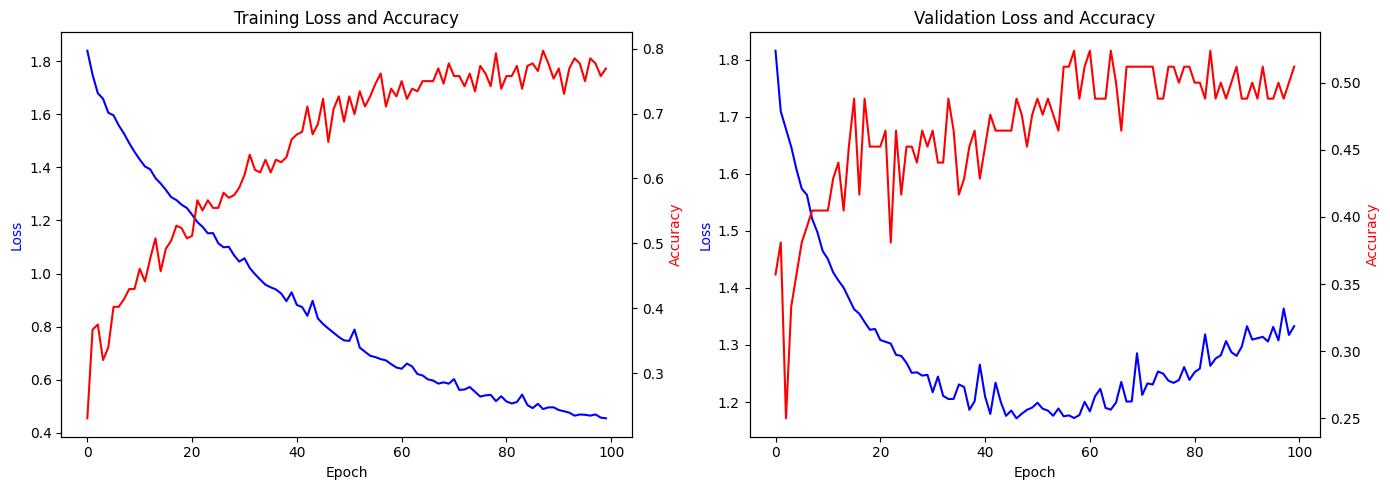

In [201]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss & Accuracy
ax1_twin = ax1.twinx()
ax1.plot(history.history['loss'], 'b-', label='Train Loss')
ax1_twin.plot(history.history['accuracy'], 'r-', label='Train Acc')

ax1.set_title('Training Loss and Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1_twin.set_ylabel('Accuracy', color='r')

# Plot 2: Validation Loss & Accuracy
ax2_twin = ax2.twinx()
ax2.plot(history.history.get('val_loss', []), 'b-', label='Val Loss')
ax2_twin.plot(history.history.get('val_accuracy', []), 'r-', label='Val Acc')

ax2.set_title('Validation Loss and Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss', color='b')
ax2_twin.set_ylabel('Accuracy', color='r')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate 
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)

# Step 1: Get predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model_curated.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report
)
from tabulate import tabulate
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = val_dataset_curated.class_names
num_classes = len(class_names)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Identify top confusion(s) per true class (with ties)
top_confusions = []
for i in range(num_classes):
    row = cm[i]
    off_diagonal = [(j, row[j]) for j in range(num_classes) if j != i and row[j] > 0]
    if off_diagonal:
        max_count = max(count for _, count in off_diagonal)
        tied = [(i, j, count) for j, count in off_diagonal if count == max_count]
        top_confusions.extend(tied)

# Print most common confusions
markdown_data = [(class_names[i], class_names[j], count) for i, j, count in top_confusions]
markdown_data.sort(key=lambda x: (x[0], -x[2]))
print('\n**Top Confusions**\n')
print(tabulate(markdown_data, headers=['True Class', 'Predicted As', 'Count'], tablefmt='github'))

# Compute and print overall metrics
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print('\n**Model Performance**\n')
metric_table = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}'],
]
print(tabulate(metric_table, headers=['Metric', 'Value'], tablefmt='github'))

# Compute and print per-class metrics
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

per_class_metrics = []
for class_name in class_names:
    row = report[class_name]
    per_class_metrics.append([
        class_name,
        f"{row['precision']:.4f}",
        f"{row['recall']:.4f}",
        f"{row['f1-score']:.4f}",
        int(row['support'])
    ])

print('\n**Per-Class Metrics**\n')
print(tabulate(
    per_class_metrics,
    headers=['Class', 'Precision', 'Recall', 'F1 Score', 'Support'],
    tablefmt='github'
))

## Transfer Learning

Create a simple model with EfficientNetB0 and one dense layer with 64 units for class discrimination with the appropriate pre-processing layer.

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

def cnn_transfer_v3(input_shape=(224, 224, 3), num_classes=5):
    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = models.Sequential([
        layers.Input(shape=input_shape),

        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

Load the data as 224x224 (required for ENet B0) and preprocess the images.

In [14]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess_dataset(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y))

In [17]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
train_dataset_224  = image_dataset_from_directory(
    './datasets/dataset_train_validate_test/dataset_train/',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=True
)

test_dataset_224  = image_dataset_from_directory(
    './datasets/dataset_train_validate_test/dataset_test/',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

val_dataset_224 =  image_dataset_from_directory(
    './datasets/dataset_train_validate_test/dataset_val//',
    image_size=(224, 224),
    batch_size=16,
    label_mode='int', # try out sparse categorical crossentropy
    shuffle=False
)

class_names = train_dataset_224.class_names
num_classes = len(class_names)
print(class_names)

train_dataset_224 = preprocess_dataset(train_dataset_224)
val_dataset_224 = preprocess_dataset(val_dataset_224)
test_dataset_224 = preprocess_dataset(val_dataset_224)

Found 2076 files belonging to 5 classes.
Found 297 files belonging to 5 classes.
Found 593 files belonging to 5 classes.
['bargraph', 'flowchart', 'linegraph', 'piechart', 'scatterplot']


In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam


model_transfer_v3 = cnn_transfer_v3(num_classes=num_classes)
checkpoint = ModelCheckpoint(
    'models/cnn_v3_best.keras',      # Save path
    monitor='val_accuracy',          # Metric to watch
    save_best_only=True,             # Only keep best
    save_weights_only=False,         # Save full model
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)


model_transfer_v3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', ]
)

history = model_transfer_v3.fit(
    train_dataset_224,
    validation_data=val_dataset_224,
    epochs=30,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5269 - loss: 1.2389 
Epoch 1: val_accuracy improved from -inf to 0.90219, saving model to models/cnn_v3_best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 169ms/step - accuracy: 0.5282 - loss: 1.2364 - val_accuracy: 0.9022 - val_loss: 0.4626
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8947 - loss: 0.4220  
Epoch 2: val_accuracy improved from 0.90219 to 0.94098, saving model to models/cnn_v3_best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.8948 - loss: 0.4218 - val_accuracy: 0.9410 - val_loss: 0.2764
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9352 - loss: 0.2684  
Epoch 3: val_accuracy improved from 0.94098 to 0.94604, saving model to models/cnn_v3_best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.9352 - loss: 0.2682 - val_accuracy: 0.9460 - val_loss: 0.2071
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9545 - loss: 0.193

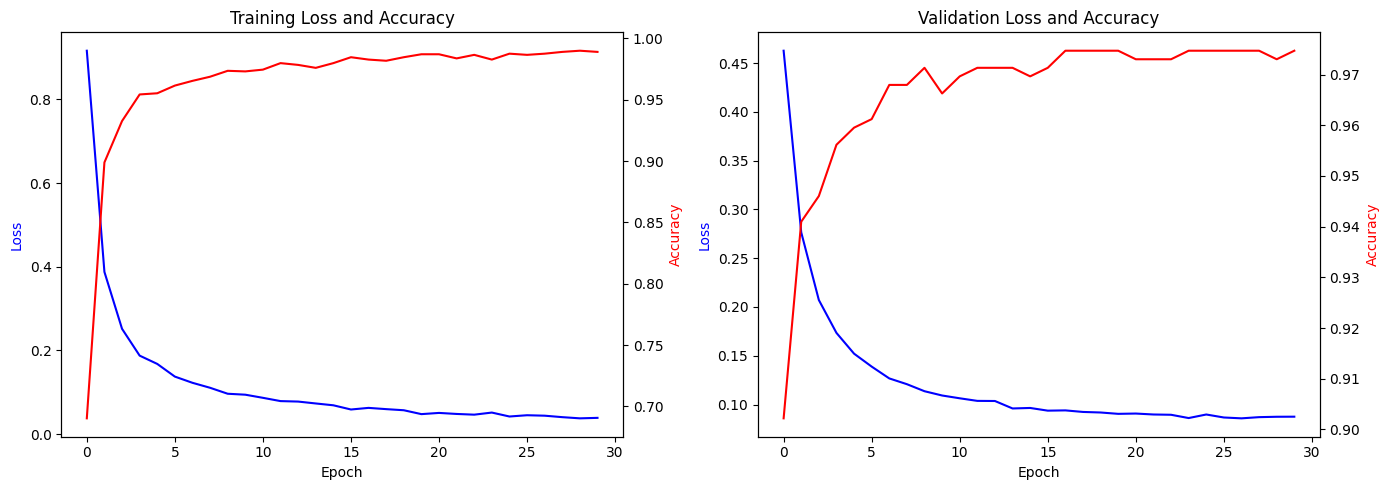

In [35]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss & Accuracy
ax1_twin = ax1.twinx()
ax1.plot(history.history['loss'], 'b-', label='Train Loss')
ax1_twin.plot(history.history['accuracy'], 'r-', label='Train Acc')

ax1.set_title('Training Loss and Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1_twin.set_ylabel('Accuracy', color='r')

# Plot 2: Validation Loss & Accuracy
ax2_twin = ax2.twinx()
ax2.plot(history.history.get('val_loss', []), 'b-', label='Val Loss')
ax2_twin.plot(history.history.get('val_accuracy', []), 'r-', label='Val Acc')

ax2.set_title('Validation Loss and Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss', color='b')
ax2_twin.set_ylabel('Accuracy', color='r')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━

2025-04-17 17:09:25.923510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


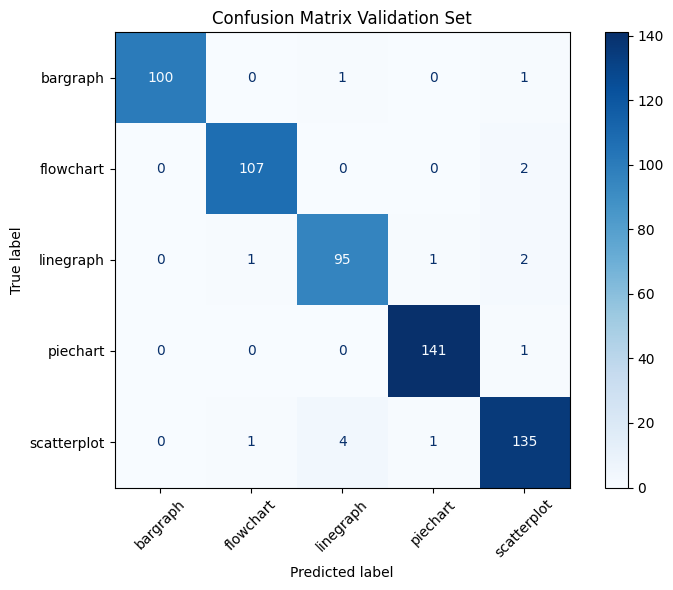


**Top Confusions**

| True Class   | Predicted As   |   Count |
|--------------|----------------|---------|
| bargraph     | linegraph      |       1 |
| bargraph     | scatterplot    |       1 |
| flowchart    | scatterplot    |       2 |
| linegraph    | scatterplot    |       2 |
| piechart     | scatterplot    |       1 |
| scatterplot  | linegraph      |       4 |

**Model Performance**

| Metric    |   Value |
|-----------|---------|
| Accuracy  |  0.9747 |
| Precision |  0.9748 |
| Recall    |  0.9747 |
| F1 Score  |  0.9747 |

**Per-Class Metrics**

| Class       |   Precision |   Recall |   F1 Score |   Support |
|-------------|-------------|----------|------------|-----------|
| bargraph    |      1      |   0.9804 |     0.9901 |       102 |
| flowchart   |      0.9817 |   0.9817 |     0.9817 |       109 |
| linegraph   |      0.95   |   0.9596 |     0.9548 |        99 |
| piechart    |      0.986  |   0.993  |     0.9895 |       142 |
| scatterplot |      0.9574 |   0.9574 

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate 
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)

# Step 1: Get predictions
y_true = []
y_pred = []

for images, labels in val_dataset_224:
    preds = model_transfer_v3.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report
)
from tabulate import tabulate
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title('Confusion Matrix Validation Set')
plt.tight_layout()
plt.show()

# Identify top confusion(s) per true class (with ties)
top_confusions = []
for i in range(num_classes):
    row = cm[i]
    off_diagonal = [(j, row[j]) for j in range(num_classes) if j != i and row[j] > 0]
    if off_diagonal:
        max_count = max(count for _, count in off_diagonal)
        tied = [(i, j, count) for j, count in off_diagonal if count == max_count]
        top_confusions.extend(tied)

# Print most common confusions
markdown_data = [(class_names[i], class_names[j], count) for i, j, count in top_confusions]
markdown_data.sort(key=lambda x: (x[0], -x[2]))
print('\n**Top Confusions**\n')
print(tabulate(markdown_data, headers=['True Class', 'Predicted As', 'Count'], tablefmt='github'))

# Compute and print overall metrics
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print('\n**Model Performance**\n')
metric_table = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}'],
]
print(tabulate(metric_table, headers=['Metric', 'Value'], tablefmt='github'))

# Compute and print per-class metrics
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

per_class_metrics = []
for class_name in class_names:
    row = report[class_name]
    per_class_metrics.append([
        class_name,
        f"{row['precision']:.4f}",
        f"{row['recall']:.4f}",
        f"{row['f1-score']:.4f}",
        int(row['support'])
    ])

print('\n**Per-Class Metrics**\n')
print(tabulate(
    per_class_metrics,
    headers=['Class', 'Precision', 'Recall', 'F1 Score', 'Support'],
    tablefmt='github'
))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━

2025-04-17 17:09:34.843952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


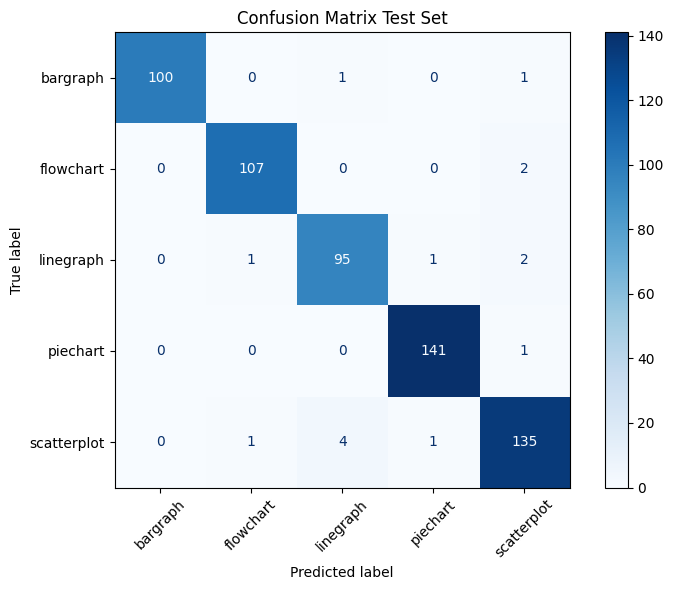


**Top Confusions**

| True Class   | Predicted As   |   Count |
|--------------|----------------|---------|
| bargraph     | linegraph      |       1 |
| bargraph     | scatterplot    |       1 |
| flowchart    | scatterplot    |       2 |
| linegraph    | scatterplot    |       2 |
| piechart     | scatterplot    |       1 |
| scatterplot  | linegraph      |       4 |

**Model Performance**

| Metric    |   Value |
|-----------|---------|
| Accuracy  |  0.9747 |
| Precision |  0.9748 |
| Recall    |  0.9747 |
| F1 Score  |  0.9747 |

**Per-Class Metrics**

| Class       |   Precision |   Recall |   F1 Score |   Support |
|-------------|-------------|----------|------------|-----------|
| bargraph    |      1      |   0.9804 |     0.9901 |       102 |
| flowchart   |      0.9817 |   0.9817 |     0.9817 |       109 |
| linegraph   |      0.95   |   0.9596 |     0.9548 |        99 |
| piechart    |      0.986  |   0.993  |     0.9895 |       142 |
| scatterplot |      0.9574 |   0.9574 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate 
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)

# Step 1: Get predictions
y_true = []
y_pred = []

for images, labels in test_dataset_224:
    preds = model_transfer_v3.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report
)
from tabulate import tabulate
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title('Confusion Matrix Test Set')
plt.tight_layout()
plt.show()

# Identify top confusion(s) per true class (with ties)
top_confusions = []
for i in range(num_classes):
    row = cm[i]
    off_diagonal = [(j, row[j]) for j in range(num_classes) if j != i and row[j] > 0]
    if off_diagonal:
        max_count = max(count for _, count in off_diagonal)
        tied = [(i, j, count) for j, count in off_diagonal if count == max_count]
        top_confusions.extend(tied)

# Print most common confusions
markdown_data = [(class_names[i], class_names[j], count) for i, j, count in top_confusions]
markdown_data.sort(key=lambda x: (x[0], -x[2]))
print('\n**Top Confusions**\n')
print(tabulate(markdown_data, headers=['True Class', 'Predicted As', 'Count'], tablefmt='github'))

# Compute and print overall metrics
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print('\n**Model Performance**\n')
metric_table = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}'],
]
print(tabulate(metric_table, headers=['Metric', 'Value'], tablefmt='github'))

# Compute and print per-class metrics
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

per_class_metrics = []
for class_name in class_names:
    row = report[class_name]
    per_class_metrics.append([
        class_name,
        f"{row['precision']:.4f}",
        f"{row['recall']:.4f}",
        f"{row['f1-score']:.4f}",
        int(row['support'])
    ])

print('\n**Per-Class Metrics**\n')
print(tabulate(
    per_class_metrics,
    headers=['Class', 'Precision', 'Recall', 'F1 Score', 'Support'],
    tablefmt='github'
))

## Inference Code Testing



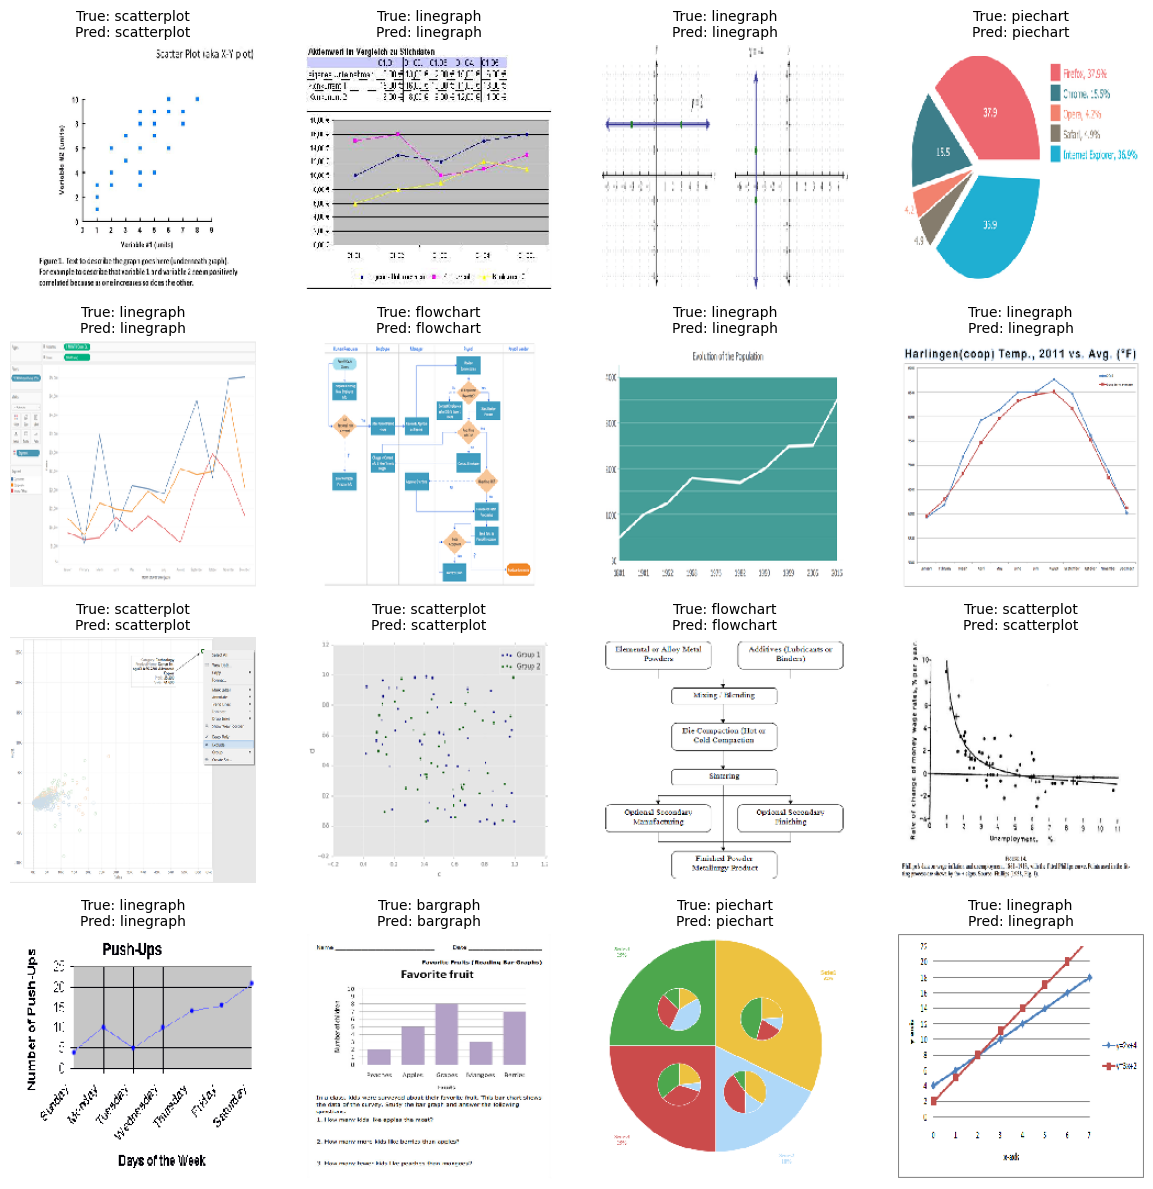

In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

dataset_root = Path('./datasets/dataset_raw')
model = load_model('models/cnn_v3_best.keras')
class_names = ['bargraph', 'flowchart', 'linegraph', 'piechart', 'scatterplot']

all_images = list(dataset_root.rglob('*.jpg')) + list(dataset_root.rglob('*.png'))
sampled_images = random.sample(all_images, 16)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for ax, img_path in zip(axes, sampled_images):
    true_class = img_path.parent.name
    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = image.img_to_array(img)
    img_arr_exp = np.expand_dims(img_arr, axis=0)
    img_arr_exp = preprocess_input(img_arr_exp)

    pred = model.predict(img_arr_exp, verbose=0)
    pred_class = class_names[np.argmax(pred)]

    ax.imshow(img)
    ax.set_title(f'True: {true_class}\nPred: {pred_class}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()